In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"dharshz","key":"d3d399b7cbb92c6a4f0378a57f0a76a7"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d puneet6060/intel-image-classification
!unzip intel-image-classification.zip -d intel_images


Streaming output truncated to the last 5000 lines.
  inflating: intel_images/seg_train/seg_train/mountain/7506.jpg  
  inflating: intel_images/seg_train/seg_train/mountain/7537.jpg  
  inflating: intel_images/seg_train/seg_train/mountain/7539.jpg  
  inflating: intel_images/seg_train/seg_train/mountain/7551.jpg  
  inflating: intel_images/seg_train/seg_train/mountain/7560.jpg  
  inflating: intel_images/seg_train/seg_train/mountain/7565.jpg  
  inflating: intel_images/seg_train/seg_train/mountain/7578.jpg  
  inflating: intel_images/seg_train/seg_train/mountain/7581.jpg  
  inflating: intel_images/seg_train/seg_train/mountain/7586.jpg  
  inflating: intel_images/seg_train/seg_train/mountain/7647.jpg  
  inflating: intel_images/seg_train/seg_train/mountain/7652.jpg  
  inflating: intel_images/seg_train/seg_train/mountain/7654.jpg  
  inflating: intel_images/seg_train/seg_train/mountain/7662.jpg  
  inflating: intel_images/seg_train/seg_train/mountain/767.jpg  
  inflating: intel_images/

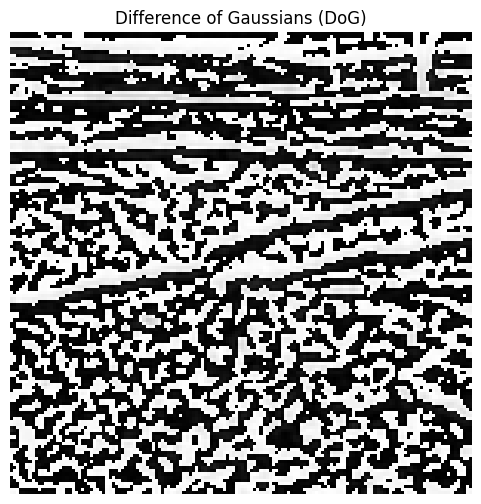

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

dataset_path = "intel_images/seg_train/seg_train/"

def compute_dog(image_path, sigma=1.0, k=1.6):

    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    blur1 = cv2.GaussianBlur(img, (0, 0), sigma)
    blur2 = cv2.GaussianBlur(img, (0, 0), sigma * k)

    dog = blur1 - blur2

    return dog

category = "glacier"
image_list = os.listdir(os.path.join(dataset_path, category))
sample_image_path = os.path.join(dataset_path, category, image_list[0])

dog_image = compute_dog(sample_image_path)

plt.figure(figsize=(6, 6))
plt.imshow(dog_image, cmap="gray")
plt.title("Difference of Gaussians (DoG)")
plt.axis("off")
plt.show()

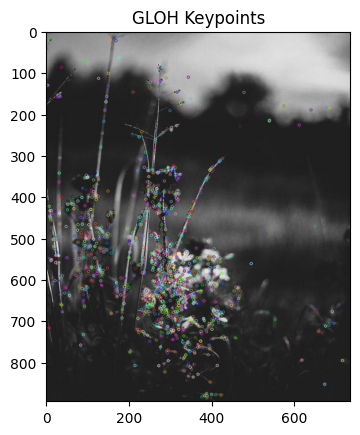

In [ ]:
from sklearn.decomposition import PCA

def compute_sift_keypoints(image):
    sift = cv2.SIFT_create()
    return sift.detectAndCompute(image, None)

def log_polar_histogram(descriptors, bins=8):
    num_keypoints, descriptor_length = descriptors.shape

    sift_desc = descriptors.reshape(num_keypoints, 16, bins)
    gl_desc = np.zeros((num_keypoints, 136))

    for i in range(num_keypoints):
        for j in range(8):
            gl_desc[i, j*17:(j+1)*17] = np.histogram(np.log1p(sift_desc[i, :, j]), bins=17, range=(0, np.log(16)+1))[0]

    return gl_desc

def apply_pca(gloh_descriptors, output_dim=128):
    if gloh_descriptors is None or gloh_descriptors.shape[0] < output_dim:
        return gloh_descriptors

    return PCA(n_components=output_dim).fit_transform(gloh_descriptors)

image = cv2.imread("flowers.jpg", cv2.IMREAD_GRAYSCALE)

keypoints, sift_descriptors = compute_sift_keypoints(image)

if sift_descriptors is not None:
    gloh_descriptors = log_polar_histogram(sift_descriptors)
    final_gloh_desc = apply_pca(gloh_descriptors)

    plt.imshow(cv2.drawKeypoints(image, keypoints, None), cmap="gray")
    plt.title("GLOH Keypoints")
    plt.show()
else:
    print("No keypoints detected.")

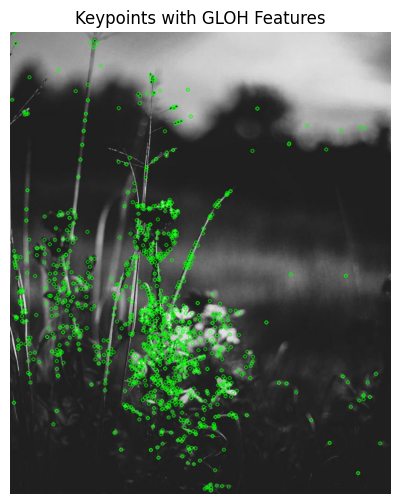

In [ ]:
image = cv2.imread('flowers.jpg', cv2.IMREAD_GRAYSCALE)

grad_x = cv2.Sobel(image, cv2.CV_32F, 1, 0, ksize=3)
grad_y = cv2.Sobel(image, cv2.CV_32F, 0, 1, ksize=3)
mag, angle = cv2.cartToPolar(grad_x, grad_y, angleInDegrees=True)

sift = cv2.SIFT_create()
keypoints, descriptors = sift.detectAndCompute(image, None)

gloh_features = []
for kp in keypoints:
    x, y = int(kp.pt[0]), int(kp.pt[1])
    scale = int(kp.size / 2)

    if (y - scale) >= 0 and (y + scale) < image.shape[0] and (x - scale) >= 0 and (x + scale) < image.shape[1]:
        histogram = cv2.calcHist([angle[y-scale:y+scale, x-scale:x+scale]], [0], None, [36], [0, 360])
        gloh_features.append(histogram.flatten())

if gloh_features:
    gloh_features = np.array(gloh_features)
else:
    print("No GLOH features extracted.")

image_with_keypoints = cv2.drawKeypoints(image, keypoints, None, color=(0, 255, 0))

plt.figure(figsize=(8, 6))
plt.imshow(image_with_keypoints, cmap="gray")
plt.title("Keypoints with GLOH Features")
plt.axis("off")
plt.show()

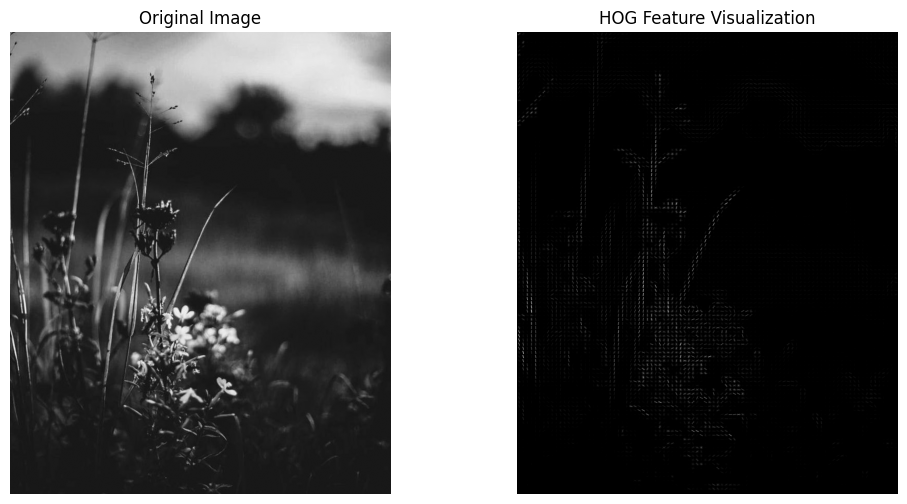

In [ ]:
from skimage.feature import hog
from skimage import color

image = cv2.imread('flowers.jpg', cv2.IMREAD_GRAYSCALE)

hog_features, hog_image = hog(image,
                              orientations=9,
                              pixels_per_cell=(8, 8),
                              cells_per_block=(2, 2),
                              visualize=True,
                              feature_vector=True)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.imshow(image, cmap='gray')
ax1.set_title("Original Image")
ax1.axis("off")

ax2.imshow(hog_image, cmap='gray')
ax2.set_title("HOG Feature Visualization")
ax2.axis("off")

plt.show()

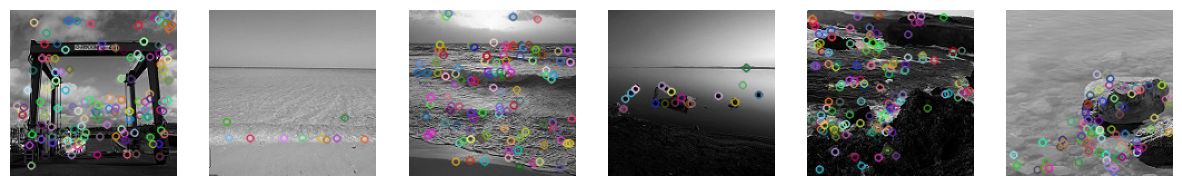

In [ ]:
import os

dataset_path = "intel_images/seg_train/seg_train/"

sift = cv2.SIFT_create()

sift_features = {}

category = "sea"
category_path = os.path.join(dataset_path, category)
images = sorted(os.listdir(category_path))[:6]

for img_name in images:
    img_path = os.path.join(category_path, img_name)

    image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

    if image is not None:
        keypoints, descriptors = sift.detectAndCompute(image, None)
        sift_features[img_name] = (keypoints, descriptors)
        output_image = cv2.drawKeypoints(image, keypoints, None,
                                         flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

import math

def show_sift(images, path, sift):
    rows = math.ceil(len(images) / 5)
    fig, axes = plt.subplots(rows, 6, figsize=(15, 3 * rows))

    for ax, img_name in zip(axes.flat, images):
        img = cv2.imread(os.path.join(path, img_name), cv2.IMREAD_GRAYSCALE)
        kp, _ = sift.detectAndCompute(img, None)
        ax.imshow(cv2.drawKeypoints(img, kp, None), cmap="gray")
        ax.axis("off")

    for ax in axes.flat[len(images):]:
        fig.delaxes(ax)

    plt.show()

show_sift(images, category_path, sift)

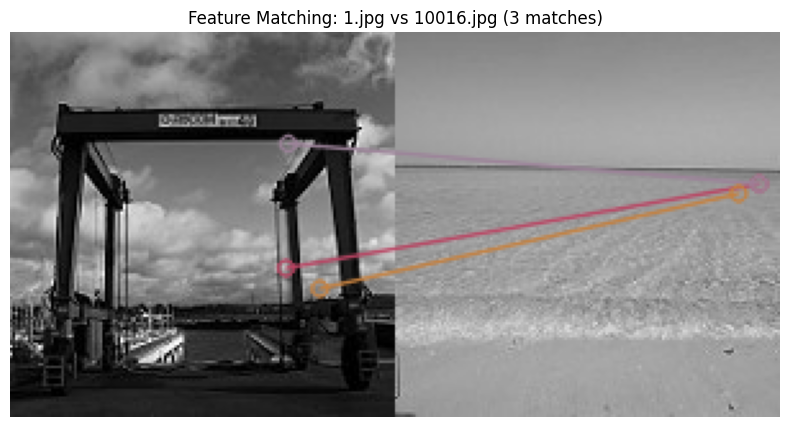

In [ ]:
def extract_sift_features(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    sift = cv2.SIFT_create(contrastThreshold=0.01, edgeThreshold=10, sigma=1.6)
    kp, desc = sift.detectAndCompute(img, None)

    return img, kp, desc

def match_sift_features(image1, image2, path):
    img1, kp1, desc1 = extract_sift_features(os.path.join(path, image1))
    img2, kp2, desc2 = extract_sift_features(os.path.join(path, image2))

    flann = cv2.FlannBasedMatcher(dict(algorithm=3, trees=10), dict(checks=30))

    matches = flann.knnMatch(desc1, desc2, k=2)
    good_matches = [m for m, n in matches if m.distance < 0.78 * n.distance]  # Stricter threshold


    matched_img = cv2.drawMatches(img1, kp1, img2, kp2, good_matches, None,
                                  flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

    plt.figure(figsize=(10, 5))
    plt.imshow(matched_img, cmap="gray")
    plt.title(f"Feature Matching: {image1} vs {image2} ({len(good_matches)} matches)")
    plt.axis("off")
    plt.show()

match_sift_features(images[0], images[1], category_path)


Number of Keypoints Detected In The Training Image:  1389
Number of Keypoints Detected In The Query Image:  1389


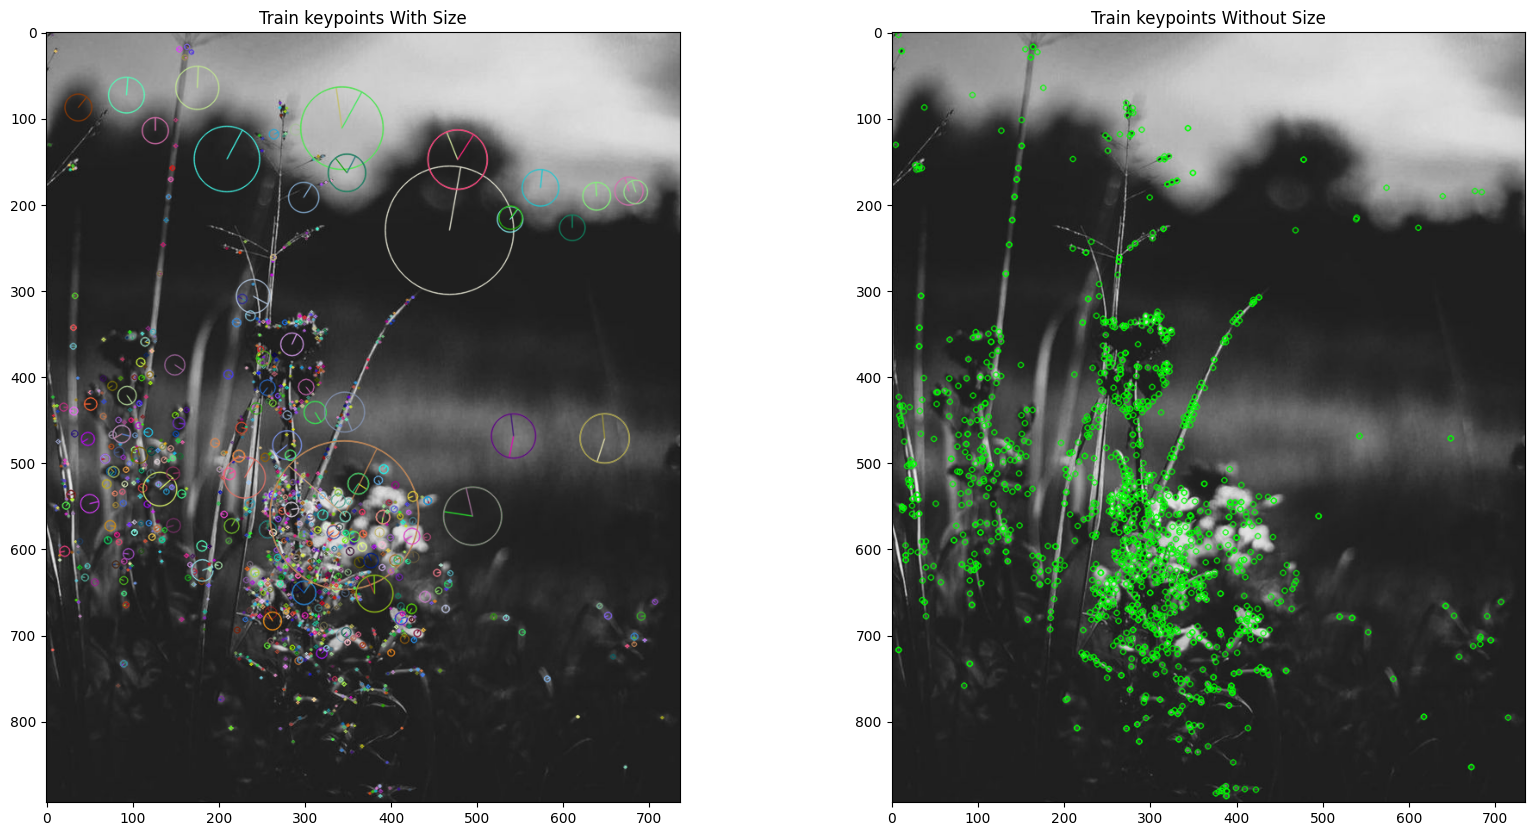

In [ ]:
training_image = cv2.imread("flowers.jpg")
test_image = cv2.imread("flowers.jpg")

training_gray = cv2.cvtColor(training_image, cv2.COLOR_BGR2GRAY)
test_gray = cv2.cvtColor(test_image, cv2.COLOR_BGR2GRAY)
sift = cv2.xfeatures2d.SIFT_create()

train_keypoints, train_descriptor = sift.detectAndCompute(training_gray, None)
test_keypoints, test_descriptor = sift.detectAndCompute(test_gray, None)

keypoints_without_size = np.copy(training_image)
keypoints_with_size = np.copy(training_image)

cv2.drawKeypoints(training_image, train_keypoints, keypoints_without_size, color = (0, 255, 0))

cv2.drawKeypoints(training_image, train_keypoints, keypoints_with_size, flags = cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

fx, plots = plt.subplots(1, 2, figsize=(20,10))

plots[0].set_title("Train keypoints With Size")
plots[0].imshow(keypoints_with_size, cmap='gray')

plots[1].set_title("Train keypoints Without Size")
plots[1].imshow(keypoints_without_size, cmap='gray')

print("Number of Keypoints Detected In The Training Image: ", len(train_keypoints))

print("Number of Keypoints Detected In The Query Image: ", len(test_keypoints))

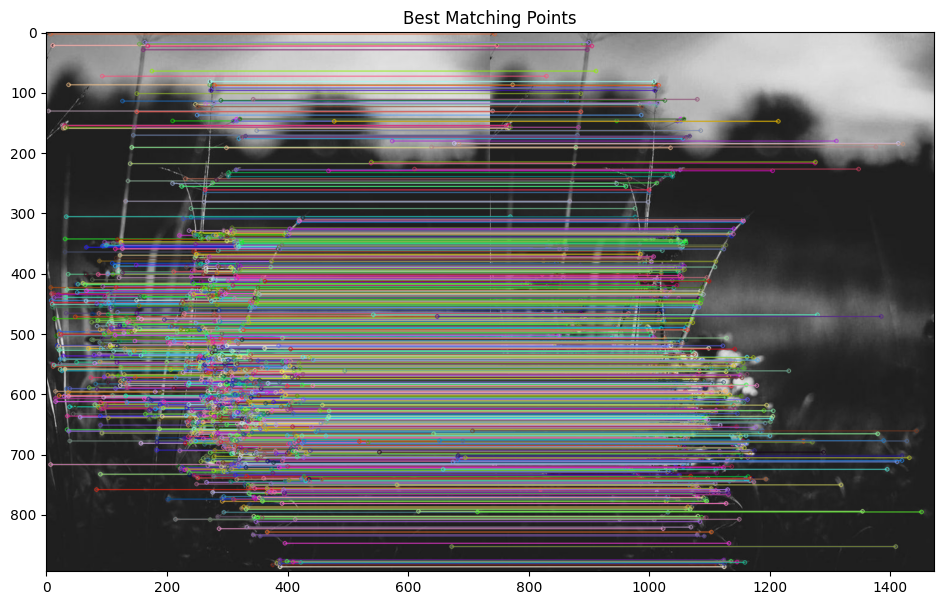


Number of Matching Keypoints Between The Training and Query Images:  1389


In [ ]:
bf = cv2.BFMatcher(cv2.NORM_L1, crossCheck = False)

matches = bf.match(train_descriptor, test_descriptor)

matches = sorted(matches, key = lambda x : x.distance)

result = cv2.drawMatches(training_image, train_keypoints, test_gray, test_keypoints, matches, test_gray, flags = 2)

plt.rcParams['figure.figsize'] = [14.0, 7.0]
plt.title('Best Matching Points')
plt.imshow(result)
plt.show()

print("\nNumber of Matching Keypoints Between The Training and Query Images: ", len(matches))

Using SIFT feature detector
Loading image paths...
Extracting features from images...


100%|██████████| 1000/1000 [00:19<00:00, 50.55it/s]


Building vocabulary with 200 visual words...
Computing histograms...


100%|██████████| 1000/1000 [00:18<00:00, 55.53it/s]


Training SVM classifier...
Evaluating model...
Accuracy: 0.9050

Classification Report:
              precision    recall  f1-score   support

    building       0.90      0.91      0.90        96
      forest       0.91      0.90      0.91       104

    accuracy                           0.91       200
   macro avg       0.90      0.91      0.90       200
weighted avg       0.91      0.91      0.91       200



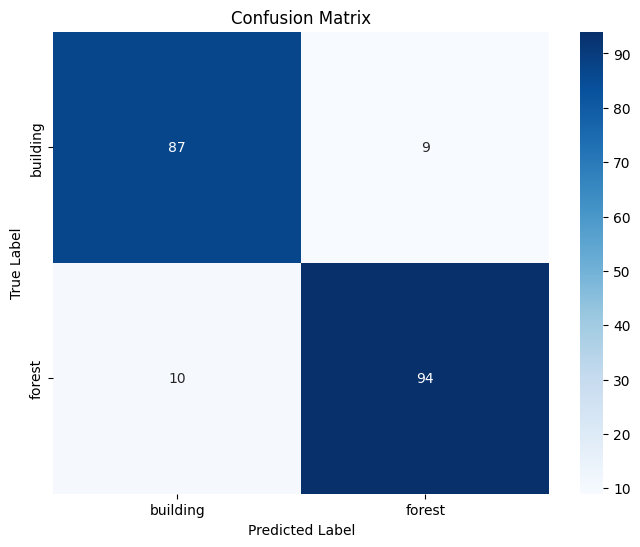

Saving model...

Example predictions:
Visualizing keypoints on sample images...


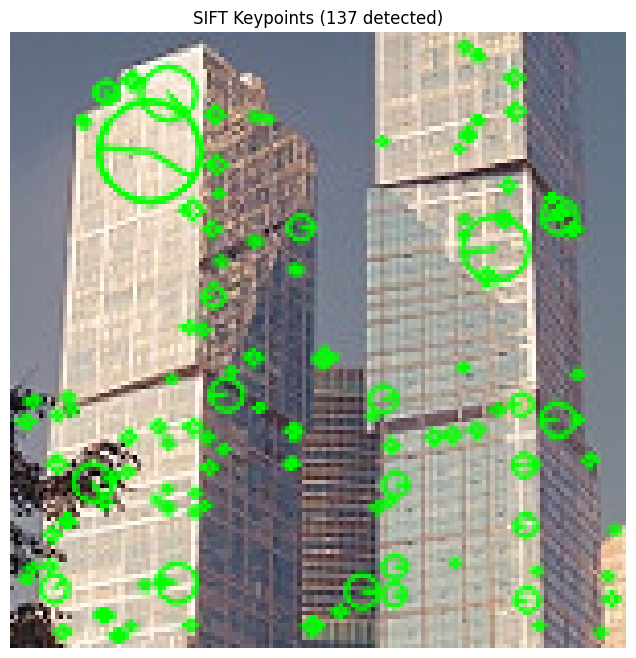

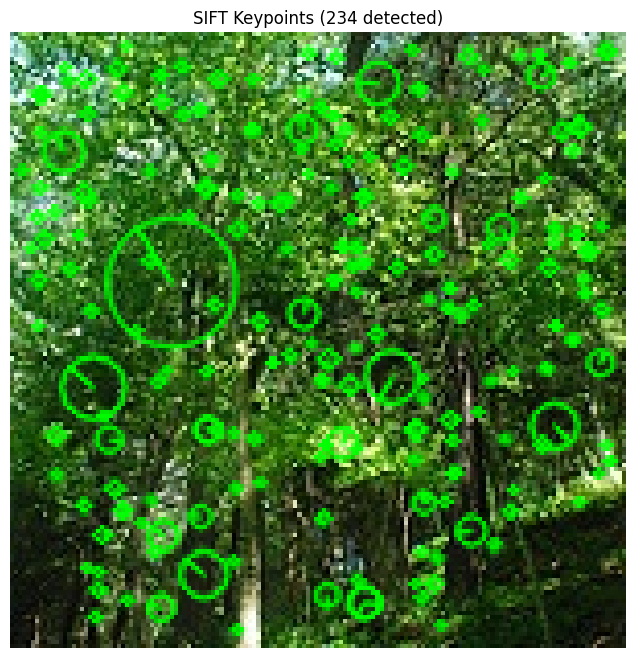

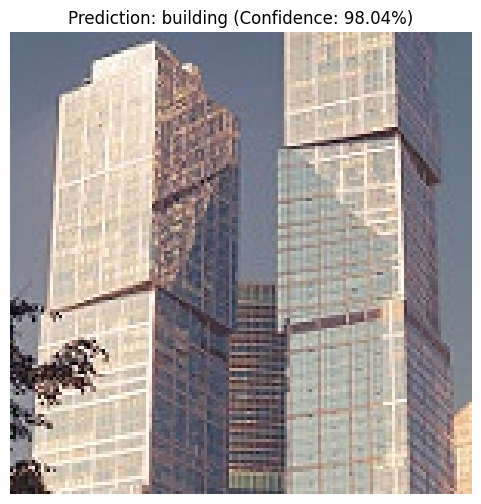

Image: 19624.jpg
Predicted class: building with 98.04% confidence



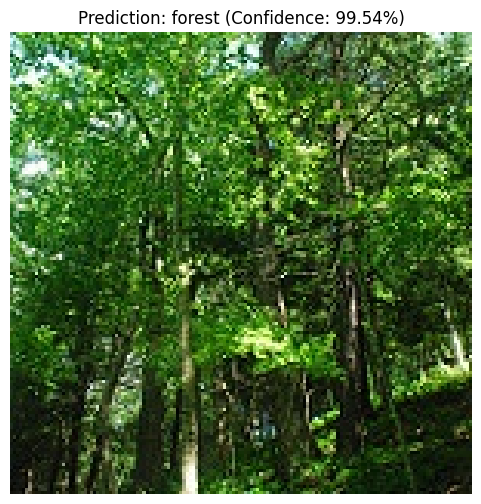

Image: 18851.jpg
Predicted class: forest with 99.54% confidence



In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
import seaborn as sns
from tqdm import tqdm
import glob
import random
import pickle

random.seed(42)
np.random.seed(42)

BASE_PATH = "intel_images/seg_train/"
TRAIN_BUILDINGS_PATH = os.path.join(BASE_PATH, "seg_train/buildings")
TRAIN_FOREST_PATH = os.path.join(BASE_PATH, "seg_train/forest")
TEST_BUILDINGS_PATH = os.path.join(BASE_PATH, "seg_test/buildings")
TEST_FOREST_PATH = os.path.join(BASE_PATH, "seg_test/forest")

MAX_IMAGES_PER_CLASS = 500
FEATURE_DETECTOR = 'SIFT'
VOCABULARY_SIZE = 200
SAMPLE_SIZE = (150, 150)

if FEATURE_DETECTOR == 'SIFT':
    detector = cv2.SIFT_create()
elif FEATURE_DETECTOR == 'SURF':
    detector = cv2.xfeatures2d.SURF_create(400)
elif FEATURE_DETECTOR == 'ORB':
    detector = cv2.ORB_create()
else:
    raise ValueError(f"Unknown feature detector: {FEATURE_DETECTOR}")

print(f"Using {FEATURE_DETECTOR} feature detector")

def load_images_from_folder(folder_path, max_images=None):
    paths = glob.glob(os.path.join(folder_path, '*.jpg'))
    if max_images:
        paths = paths[:max_images]
    return paths

def extract_features(image_path, detector):
    image = cv2.imread(image_path)
    if image is None:
        print(f"Warning: Could not read image {image_path}")
        return None

    image = cv2.resize(image, SAMPLE_SIZE)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    keypoints, descriptors = detector.detectAndCompute(gray, None)
    return keypoints, descriptors, image

def build_vocabulary(descriptors_list, vocabulary_size):
    all_descriptors = np.vstack(descriptors_list)
    print(f"Building vocabulary with {vocabulary_size} visual words...")
    kmeans = KMeans(n_clusters=vocabulary_size, random_state=42, n_init=10)
    kmeans.fit(all_descriptors)
    return kmeans

def compute_histogram(descriptors, kmeans):
    if descriptors is None or len(descriptors) == 0:
        return np.zeros(kmeans.n_clusters)
    clusters = kmeans.predict(descriptors)
    histogram = np.zeros(kmeans.n_clusters)
    for cluster in clusters:
        histogram[cluster] += 1
    if np.sum(histogram) > 0:
        histogram = histogram / np.sum(histogram)
    return histogram

print("Loading image paths...")
building_paths = load_images_from_folder(TRAIN_BUILDINGS_PATH, MAX_IMAGES_PER_CLASS)
forest_paths = load_images_from_folder(TRAIN_FOREST_PATH, MAX_IMAGES_PER_CLASS)

all_paths = building_paths + forest_paths
all_labels = [0] * len(building_paths) + [1] * len(forest_paths)

print("Extracting features from images...")
all_descriptors = []
valid_paths = []
valid_labels = []

for i, path in enumerate(tqdm(all_paths)):
    result = extract_features(path, detector)
    if result is not None:
        _, descriptors, _ = result
        if descriptors is not None and len(descriptors) > 0:
            all_descriptors.append(descriptors)
            valid_paths.append(path)
            valid_labels.append(all_labels[i])

vocabulary = build_vocabulary(all_descriptors, VOCABULARY_SIZE)

print("Computing histograms...")
all_histograms = []

for i, path in enumerate(tqdm(valid_paths)):
    _, descriptors, _ = extract_features(path, detector)
    if descriptors is not None and len(descriptors) > 0:
        histogram = compute_histogram(descriptors, vocabulary)
        all_histograms.append(histogram)

X = np.array(all_histograms)
y = np.array(valid_labels)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training SVM classifier...")
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(kernel='rbf', C=10, gamma='scale', probability=True))
])

pipeline.fit(X_train, y_train)

print("Evaluating model...")
y_pred = pipeline.predict(X_test)
accuracy = np.mean(y_pred == y_test)
print(f"Accuracy: {accuracy:.4f}")

print("\nClassification Report:")
target_names = ['building', 'forest']
print(classification_report(y_test, y_pred, target_names=target_names))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig('confusion_matrix_sift.png')
plt.show()

print("Saving model...")
with open('intel_image_classifier_sift.pkl', 'wb') as f:
    pickle.dump({'vocabulary': vocabulary, 'classifier': pipeline}, f)

def predict_image(image_path, vocabulary, classifier):
    keypoints, descriptors, image = extract_features(image_path, detector)
    if descriptors is None or len(descriptors) == 0:
        print(f"No features found in {image_path}")
        return None, None, image
    histogram = compute_histogram(descriptors, vocabulary)
    prediction = classifier.predict([histogram])[0]
    probabilities = classifier.predict_proba([histogram])[0]
    class_name = target_names[prediction]
    confidence = probabilities[prediction] * 100
    return class_name, confidence, image

def visualize_keypoints(image_path, detector):
    keypoints, _, image = extract_features(image_path, detector)
    image_with_keypoints = cv2.drawKeypoints(image, keypoints, None, color=(0, 255, 0),
                                            flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    image_with_keypoints = cv2.cvtColor(image_with_keypoints, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(10, 8))
    plt.imshow(image_with_keypoints)
    plt.title(f"{FEATURE_DETECTOR} Keypoints ({len(keypoints)} detected)")
    plt.axis('off')
    plt.savefig(f'keypoints_{FEATURE_DETECTOR.lower()}.png')
    plt.show()

print("\nExample predictions:")
sample_building = random.choice(building_paths)
sample_forest = random.choice(forest_paths)

print("Visualizing keypoints on sample images...")
visualize_keypoints(sample_building, detector)
visualize_keypoints(sample_forest, detector)

loaded_model = {'vocabulary': vocabulary, 'classifier': pipeline}

for sample_path in [sample_building, sample_forest]:
    class_name, confidence, image = predict_image(sample_path, loaded_model['vocabulary'], loaded_model['classifier'])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(6, 6))
    plt.imshow(image)
    plt.title(f"Prediction: {class_name} (Confidence: {confidence:.2f}%)")
    plt.axis('off')
    plt.show()
    print(f"Image: {os.path.basename(sample_path)}")
    print(f"Predicted class: {class_name} with {confidence:.2f}% confidence")
    print()


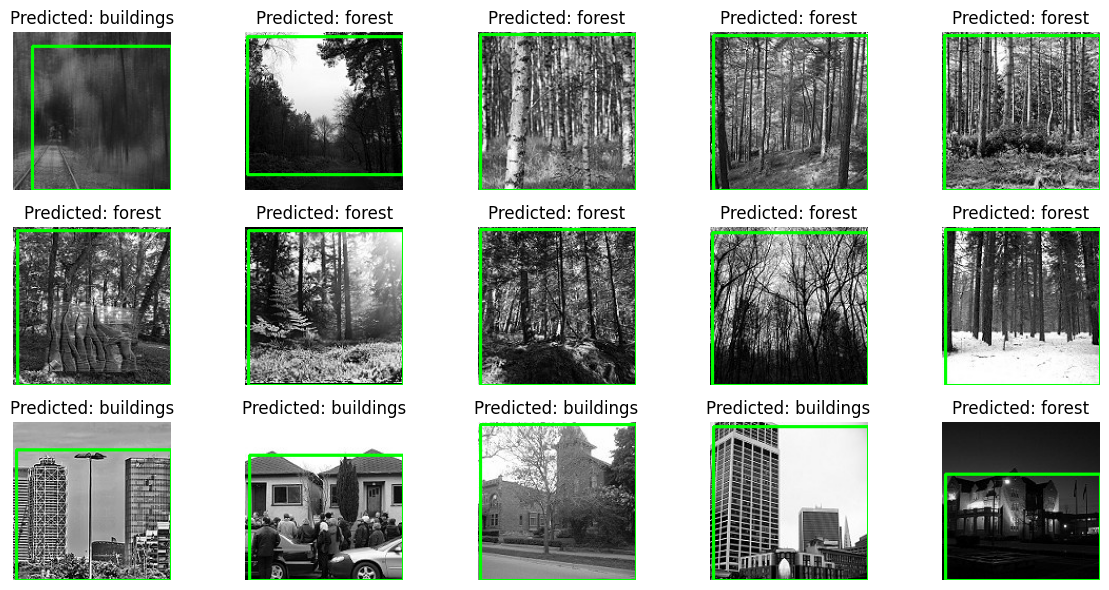

In [ ]:
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import os
import cv2
import numpy as np

BASE_PATH = "intel_images/seg_train/"
BASE_PATH2 = "intel_images/seg_test/"

TRAIN_BUILDINGS_PATH = os.path.join(BASE_PATH, "buildings")
TRAIN_FOREST_PATH = os.path.join(BASE_PATH, "forest")
TEST_BUILDINGS_PATH = os.path.join(BASE_PATH2, "buildings")
TEST_FOREST_PATH = os.path.join(BASE_PATH2, "forest")

categories = ["forest", "buildings"]
image_paths = []
true_labels = []

for idx, category in enumerate(categories):
    folder = os.path.join(BASE_PATH, f"seg_train/{category}")
    for img_file in os.listdir(folder)[:100]:
        if img_file.endswith(('.jpg', '.png')):
            image_paths.append(os.path.join(folder, img_file))
            true_labels.append(idx)

images = []
for img_path in image_paths:
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        continue
    images.append(img)

true_labels = np.array(true_labels[:len(images)])

test_image_paths = []
test_labels = []
for idx, category in enumerate(categories):
    folder = os.path.join(BASE_PATH2, f"seg_test/{category}")
    for img_file in os.listdir(folder)[:10]:
        if img_file.endswith(('.jpg', '.png')):
            test_image_paths.append(os.path.join(folder, img_file))
            test_labels.append(idx)

test_images = []
for img_path in test_image_paths:
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        continue
    test_images.append(img)

test_labels = np.array(test_labels[:len(test_images)])

FEATURE_DETECTOR = 'SIFT'
if FEATURE_DETECTOR == 'SIFT':
    detector = cv2.SIFT_create()
    descriptor_size = 128
elif FEATURE_DETECTOR == 'SURF':
    if hasattr(cv2, 'xfeatures2d'):
        detector = cv2.xfeatures2d.SURF_create(400)
        descriptor_size = 64
    else:
        raise ImportError("SURF is not available in your OpenCV version.")
elif FEATURE_DETECTOR == 'ORB':
    detector = cv2.ORB_create()
    descriptor_size = 32
else:
    raise ValueError(f"Unknown feature detector: {FEATURE_DETECTOR}")

def extract_features(image):
    if image is None or image.size == 0:
        return np.zeros(descriptor_size)
    resized_img = cv2.resize(image, (64, 128), interpolation=cv2.INTER_AREA)
    keypoints, descriptors = detector.detectAndCompute(resized_img, None)
    if descriptors is None or len(descriptors) == 0:
        return np.zeros(descriptor_size)
    feature_vector = np.mean(descriptors, axis=0)
    if feature_vector.shape[0] != descriptor_size:
        feature_vector = np.pad(feature_vector, (0, descriptor_size - feature_vector.shape[0]), mode='constant')
    return feature_vector

feature_list = []
for img in images:
    features = extract_features(img)
    feature_list.append(features)

feature_matrix = np.array(feature_list)
scaler = StandardScaler()
feature_matrix_scaled = scaler.fit_transform(feature_matrix)

num_clusters = 2
kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
kmeans.fit(feature_matrix_scaled)

rfc = RandomForestClassifier(n_estimators=100, random_state=42)
rfc.fit(feature_matrix_scaled, true_labels)

predictions = []
bounding_boxes = []

for test_img in test_images:
    test_features = extract_features(test_img)
    test_features_scaled = scaler.transform([test_features])
    predicted_label = rfc.predict(test_features_scaled)[0]
    predictions.append(predicted_label)
    keypoints, _ = detector.detectAndCompute(test_img, None)
    if keypoints:
        x_coords = [int(kp.pt[0]) for kp in keypoints]
        y_coords = [int(kp.pt[1]) for kp in keypoints]
        x, y = min(x_coords), min(y_coords)
        w = max(x_coords) - x + 30
        h = max(y_coords) - y + 30
        h, w = min(h, test_img.shape[0] - y), min(w, test_img.shape[1] - x)
    else:
        x, y, w, h = 20, 20, 80, 80
    bounding_boxes.append((x, y, w, h))

plt.figure(figsize=(12, 6))
for i in range(min(len(test_images), 15)):
    test_img = test_images[i]
    pred_label = categories[predictions[i]]
    output_image = cv2.cvtColor(test_img, cv2.COLOR_GRAY2BGR)
    keypoints_img = cv2.drawKeypoints(test_img, [], output_image, (0, 255, 0),
                                      flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    x, y, w, h = bounding_boxes[i]
    cv2.rectangle(keypoints_img, (x, y), (x + w, y + h), (0, 255, 0), 2)
    plt.subplot(3, 5, i + 1)
    plt.imshow(cv2.cvtColor(keypoints_img, cv2.COLOR_BGR2RGB))
    plt.title(f"Predicted: {pred_label}")
    plt.axis('off')
plt.tight_layout()
plt.show()
